In [1]:
"""
README

Initial work on getting segmentation to work via detect.py

Before running this, do the following:

0.
You may need to install PyTables via
pip install git+https://github.com/PyTables/PyTables

This may requiring installing other dependencies (it will tell you)

Reason: http://stackoverflow.com/questions/25980018/importerror-hdfstore-requires-pytables-no-module-named-tables

1.
Download the entire repo of https://github.com/sergeyk/selective_search_ijcv_with_python
and put the directory as caffe/python/selective_search_ijcv_with_python

If you want to run selective_search in get_frame_jpegs.ipynb, you may need to add the directory to this directory (segmentation) as well.

2.
In caffe/python/caffe/detector.py:
Change
predictions = out[self.outputs[0]].squeeze(axis=(2,3))
To
predictions = out[self.outputs[0]].squeeze()

Reason: https://github.com/BVLC/caffe/issues/2041

3.
Run the first few cells in get_frame_jpegs.ipynb to generate jpeg files for the frames.

You will have to change the following path:
# NOTE: output_dir must be absolute path (if you want to use selective_search in the later cells)
output_dir = '/Users/alvinyuan/Documents/Vision/smartCams/smartCams/segmentation/video_frame_jpegs/'

4.
Change CAFFE_ROOT in detect.py.

Be sure to use detect.py in this directory (segmentation) and not the one in caffe/python/
This latter point should already be the case in this notebook.

5.
Change CAFFE_ROOT in the next code cell.
"""

"\nREADME\n\nInitial work on getting segmentation to work via detect.py\n\nBefore running this, do the following:\n\n0.\nYou may need to install PyTables via\npip install git+https://github.com/PyTables/PyTables\n\nThis may requiring installing other dependencies (it will tell you)\n\nReason: http://stackoverflow.com/questions/25980018/importerror-hdfstore-requires-pytables-no-module-named-tables\n\n1.\nIn caffe/python/caffe/detector.py:\nChange\npredictions = out[self.outputs[0]].squeeze(axis=(2,3))\nTo\npredictions = out[self.outputs[0]].squeeze()\n\nReason: https://github.com/BVLC/caffe/issues/2041\n\n2.\nRun the first few cells in get_frame_jpegs.ipynb to generate jpeg files for the frames.\n\nYou will have to change the following path:\n# NOTE: output_dir must be absolute path\noutput_dir = '/Users/alvinyuan/Documents/Vision/smartCams/smartCams/segmentation/video_frame_jpegs/'\n\n3.\nChange CAFFE_ROOT in detect.py.\n\nBe sure to use detect.py in this directory (segmentation) and n

[R-CNN](https://github.com/rbgirshick/rcnn) is a state-of-the-art detector that classifies region proposals by a finetuned Caffe model. For the full details of the R-CNN system and model, refer to its project site and the paper:

> *Rich feature hierarchies for accurate object detection and semantic segmentation*. Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. CVPR 2014. [Arxiv 2013](http://arxiv.org/abs/1311.2524).

In this example, we do detection by a pure Caffe edition of the R-CNN model for ImageNet. The R-CNN detector outputs class scores for the 200 detection classes of ILSVRC13. Keep in mind that these are raw one vs. all SVM scores, so they are not probabilistically calibrated or exactly comparable across classes. Note that this off-the-shelf model is simply for convenience, and is not the full R-CNN model.

Let's run detection on an image of a bicyclist riding a fish bike in the desert (from the ImageNet challenge—no joke).

First, we'll need region proposals and the Caffe R-CNN ImageNet model:

- [Selective Search](http://koen.me/research/selectivesearch/) is the region proposer used by R-CNN. The [selective_search_ijcv_with_python](https://github.com/sergeyk/selective_search_ijcv_with_python) Python module takes care of extracting proposals through the selective search MATLAB implementation. To install it, download the module and name its directory `selective_search_ijcv_with_python`, run the demo in MATLAB to compile the necessary functions, then add it to your `PYTHONPATH` for importing. (If you have your own region proposals prepared, or would rather not bother with this step, [detect.py](https://github.com/BVLC/caffe/blob/master/python/detect.py) accepts a list of images and bounding boxes as CSV.)

-Run `./scripts/download_model_binary.py models/bvlc_reference_rcnn_ilsvrc13` to get the Caffe R-CNN ImageNet model.

With that done, we'll call the bundled `detect.py` to generate the region proposals and run the network. For an explanation of the arguments, do `./detect.py --help`.

In [2]:
CAFFE_ROOT = '/Users/alvinyuan/Documents/Vision/caffe'

In [15]:
!mkdir -p _temp
!echo `pwd`/video_frame_jpegs/frame_47.jpg > _temp/det_input.txt
!./detect.py _temp/det_input.txt _temp/det_output.h5

CPU mode
I0502 01:20:29.113862 1927684880 net.cpp:42] Initializing net from parameters: 
name: "R-CNN-ilsvrc13"
input: "data"
input_dim: 10
input_dim: 3
input_dim: 227
input_dim: 227
state {
  phase: TEST
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 96
    kernel_size: 11
    stride: 4
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "pool1"
  top: "norm1"
  lrn_param {
    local_size: 5
    alpha: 0.0001
    beta: 0.75
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "norm1"
  top: "conv2"
  convolution_param {
    num_output: 256
    pad: 2
    kernel_size: 5
    group: 2
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "pool2"
  ty

This run was in GPU mode. For CPU mode detection, call `detect.py` without the `--gpu` argument.

Running this outputs a DataFrame with the filenames, selected windows, and their detection scores to an HDF5 file.
(We only ran on one image, so the filenames will all be the same.)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_hdf('_temp/det_output.h5', 'df')
print(df.shape)
print(df.iloc[0])

(1214, 5)
prediction    [-2.72931, -2.19597, -2.36118, -2.48439, -2.08...
ymin                                                          0
xmin                                                     591.36
ymax                                                     352.36
xmax                                                     959.08
Name: /Users/alvinyuan/Documents/Vision/smartCams/smartCams/segmentation/video_frame_jpegs/frame_47.jpg, dtype: object


1570 regions were proposed with the R-CNN configuration of selective search. The number of proposals will vary from image to image based on its contents and size -- selective search isn't scale invariant.

In general, `detect.py` is most efficient when running on a lot of images: it first extracts window proposals for all of them, batches the windows for efficient GPU processing, and then outputs the results.
Simply list an image per line in the `images_file`, and it will process all of them.

Although this guide gives an example of R-CNN ImageNet detection, `detect.py` is clever enough to adapt to different Caffe models’ input dimensions, batch size, and output categories. You can switch the model definition and pretrained model as desired. Refer to `python detect.py --help` for the parameters to describe your data set. There's no need for hardcoding.

Anyway, let's now load the ILSVRC13 detection class names and make a DataFrame of the predictions. Note you'll need the auxiliary ilsvrc2012 data fetched by `data/ilsvrc12/get_ilsvrc12_aux.sh`.

In [17]:
with open(CAFFE_ROOT + '/data/ilsvrc12/det_synset_words.txt') as f:
    labels_df = pd.DataFrame([
        {
            'synset_id': l.strip().split(' ')[0],
            'name': ' '.join(l.strip().split(' ')[1:]).split(',')[0]
        }
        for l in f.readlines()
    ])
labels_df.sort('synset_id')
predictions_df = pd.DataFrame(np.vstack(df.prediction.values), columns=labels_df['name'])
print(predictions_df.iloc[0])

name
accordion         -2.729311
airplane          -2.195969
ant               -2.361183
antelope          -2.484389
apple             -2.080250
armadillo         -1.969284
artichoke         -2.183504
axe               -2.641294
baby bed          -2.575866
backpack          -1.980197
bagel             -2.284471
balance beam      -2.221122
banana            -2.995420
band aid          -1.721611
banjo             -1.820307
baseball          -1.784528
basketball        -1.766692
bathing cap       -2.178222
beaker            -2.326337
bear              -2.873623
bee               -2.531346
bell pepper       -1.994268
bench             -2.047374
bicycle           -3.137219
binder            -2.532075
bird              -3.400307
bookshelf         -2.613939
bow tie           -2.427640
bow               -2.236877
bowl              -2.430533
                     ...   
strawberry        -2.206327
stretcher         -2.049088
sunglasses        -1.762004
swimming trunks   -2.049101
swine          

Let's look at the activations.

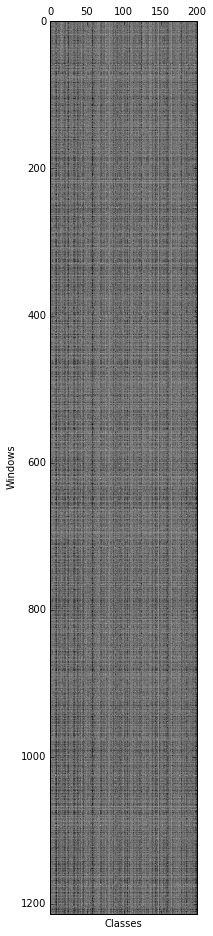

In [18]:
plt.gray()
plt.matshow(predictions_df.values)
plt.xlabel('Classes')
plt.ylabel('Windows')

Now let's take max across all windows and plot the top classes.

In [19]:
max_s = predictions_df.max(0)
max_s.sort(ascending=False)
print(max_s[:10])

name
car            1.721858
flute         -0.148220
screwdriver   -0.441462
motorcycle    -0.506672
ruler         -0.630434
spatula       -0.698324
airplane      -0.722430
bus           -0.756242
golfcart      -0.766841
crutch        -0.805576
dtype: float32


The top detections are in fact a person and bicycle.
Picking good localizations is a work in progress; we pick the top-scoring person and bicycle detections.

Top detection:
name
car               1.721858
remote control   -0.968463
binder           -1.194279
sheep            -1.224593
bowl             -1.289752
dtype: float32



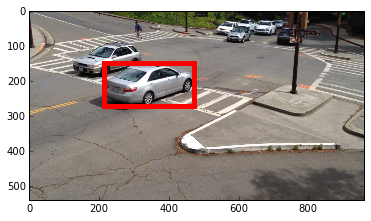

In [20]:
# Find, print, and display the top detections: car
i = predictions_df['car'].argmax()

# Show top predictions for top detection.
f = pd.Series(df['prediction'].iloc[i], index=labels_df['name'])
print('Top detection:')
print(f.order(ascending=False)[:5])
print('')

# Show top detection in red.
im = plt.imread('video_frame_jpegs/frame_47.jpg')
plt.imshow(im)
currentAxis = plt.gca()

det = df.iloc[i]
coords = (det['xmin'], det['ymin']), det['xmax'] - det['xmin'], det['ymax'] - det['ymin']
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=5))

That's cool. Let's take all 'bicycle' detections and NMS them to get rid of overlapping windows.

In [21]:
def nms_detections(dets, overlap=0.3):
    """
    Non-maximum suppression: Greedily select high-scoring detections and
    skip detections that are significantly covered by a previously
    selected detection.

    This version is translated from Matlab code by Tomasz Malisiewicz,
    who sped up Pedro Felzenszwalb's code.

    Parameters
    ----------
    dets: ndarray
        each row is ['xmin', 'ymin', 'xmax', 'ymax', 'score']
    overlap: float
        minimum overlap ratio (0.3 default)

    Output
    ------
    dets: ndarray
        remaining after suppression.
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    ind = np.argsort(dets[:, 4])

    w = x2 - x1
    h = y2 - y1
    area = (w * h).astype(float)

    pick = []
    while len(ind) > 0:
        i = ind[-1]
        pick.append(i)
        ind = ind[:-1]

        xx1 = np.maximum(x1[i], x1[ind])
        yy1 = np.maximum(y1[i], y1[ind])
        xx2 = np.minimum(x2[i], x2[ind])
        yy2 = np.minimum(y2[i], y2[ind])

        w = np.maximum(0., xx2 - xx1)
        h = np.maximum(0., yy2 - yy1)

        wh = w * h
        o = wh / (area[i] + area[ind] - wh)

        ind = ind[np.nonzero(o <= overlap)[0]]

    return dets[pick, :]

In [22]:
scores = predictions_df['car']
windows = df[['xmin', 'ymin', 'xmax', 'ymax']].values
dets = np.hstack((windows, scores[:, np.newaxis]))
nms_dets = nms_detections(dets)

Show top 3 NMS'd detections for 'bicycle' in the image and note the gap between the top scoring box (red) and the remaining boxes.

scores: [ 1.72185838  0.93253767 -0.05602837]


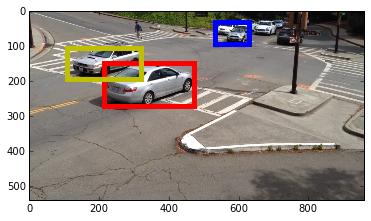

In [23]:
plt.imshow(im)
currentAxis = plt.gca()
colors = ['r', 'b', 'y']
for c, det in zip(colors, nms_dets[:3]):
    currentAxis.add_patch(
        plt.Rectangle((det[0], det[1]), det[2]-det[0], det[3]-det[1],
        fill=False, edgecolor=c, linewidth=5)
    )
print 'scores:', nms_dets[:3, 4]

This was an easy instance for bicycle as it was in the class's training set. However, the person result is a true detection since this was not in the set for that class.

You should try out detection on an image of your own next!

(Remove the temp directory to clean up, and we're done.)

In [12]:
!rm -rf _temp